### Imports

In [190]:
import pysimdamicm as ccd

import ROOT

import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt

In [191]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from skimage.measure import label, regionprops

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [192]:
plt.rcParams["text.usetex"] = False

### Calibration

In [193]:
# Start with 1 raw image CCD (just took the first image 5)
path = "raw_img_data/avg_Image_5_Low_Temp_109_20250807_170213_15.fz"
json_file = "img_5.json"

In [194]:
from pysimdamicm.scripts.calibrate import calibrate
# return array ONLY
# 
calibrated_img = calibrate(path, json_file, save=False, return_array=True)

[1/8] Loading configuration...
[2/8] Building RawData object...
WARNING ERROR: Parameter ampdir will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter itgtime will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter ampl will be ignored, not found in the data image header (extension 1)
WARNING ERROR: Parameter read_time will be ignored, not found in the data image header (extension 1)
<panaSKImg> info: Fits file does not contain an skip image, Nskips sets to 1 (from header 500).
[3/8] Preparing data...
RawData INFO.
 *********************************************************************** 
 * Define mask for sensor and over/pre-scan regions 'avg_Image_5_Low_Temp_109_20250807_170213_15.fz'
 *********************************************************************** 
  INFO: Rows and column region for the overscan, prescan and Active regions:
     amplifier EXT1 - image: 	 320 rows [0,319] and 640 cols [0,639]
     amplifie

In [195]:
ccds = np.vsplit(calibrated_img, 4)

In [196]:
ccd1, ccd2, ccd3, ccd4 = ccds

### Helpers

In [197]:
# helper to make threshold cut to image to remove noise
def apply_percentile_threshold(cal_img, percentile=95, fill_value=np.nan):
    """
    Apply a global percentile cut on the RAW calibrated image (E in e-).
    Pixels <= threshold are set to `fill_value` (np.nan by default).

    Returns:
      masked_img : 2D array with only >thr pixels kept
      thr        : numeric threshold used
      keep       : boolean mask (True for kept pixels)
    """
    thr = np.percentile(cal_img, percentile)  # compute on RAW E
    keep = cal_img > thr                      # strict '>' to drop exactly bottom p%
    masked_img = np.where(keep, cal_img, fill_value)
    return masked_img, thr, keep

In [198]:
def make_samples_from_masked(masked_img):
    """
    Build N x 3 samples from an already-thresholded image.
    Accepts either NaN-filled backgrounds or zeros; only finite, >0 values are used.
    Returns:
      X_raw : (N,3) with columns [y, x, log1p(E)]
      idx_yx: (N,2) integer pixel coords [y, x]
    """
    # valid pixels are finite and > 0
    valid = np.isfinite(masked_img) & (masked_img > 0)
    ys, xs = np.nonzero(valid)
    E = masked_img[ys, xs].astype(np.float64)

    # 3-D features for GMM
    X_raw = np.column_stack([ys, xs, np.log1p(E)])
    idx_yx = np.column_stack([ys, xs])
    return X_raw, idx_yx

In [199]:
REG_COVAR = 1e-6
RANDOM_STATE = 209

def _unscale_covariances(gmm, scaler):
    """
    Map covariances from standardized space back to original feature space.
    Handles only covariance_type='full' (what you're using).
    """
    if gmm.covariance_type != "full":
        raise ValueError("This helper currently assumes covariance_type='full'.")

    D = np.diag(scaler.scale_)
    covs_std = gmm.covariances_                 # shape: (K, d, d)
    covs_raw = np.empty_like(covs_std)
    for k in range(covs_std.shape[0]):
        covs_raw[k] = D @ covs_std[k] @ D       # Σ_raw = D Σ_std D
    return covs_raw

def fit_gmms_over_K(X_raw, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE):
    """
    Standardize features, fit a full-covariance GMM for each K.
    Returns: list of dicts with model, labels, BIC, AIC, scaler, and
             means/covariances mapped back to ORIGINAL units.
    """
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_raw)

    results = []
    for K in K_RANGE:
        gmm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            reg_covar=reg_covar,
            random_state=random_state
        )
        gmm.fit(X_std)

        # Predict labels in standardized space, but keep for reference
        labels = gmm.predict(X_std)

        # --- NEW: parameters in original (unscaled) space ---
        means_raw = scaler.inverse_transform(gmm.means_)       # shape: (K, d)
        covs_raw  = _unscale_covariances(gmm, scaler)          # shape: (K, d, d)

        bic = gmm.bic(X_std)
        aic = gmm.aic(X_std)
        results.append({
            "K": K,
            "model": gmm,
            "labels": labels,         # labels on the standardized X
            "bic": bic,
            "aic": aic,
            "scaler": scaler,
            "means_raw": means_raw,   # <-- in original units
            "covs_raw": covs_raw      # <-- in original units
        })

    results.sort(key=lambda r: r["bic"])
    return results


In [200]:
def plot_fullframe_clusters(idx_yx, labels, frame_size=(320, 640), title=None):
    H, W = frame_size
    y, x = idx_yx[:, 0], idx_yx[:, 1]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    sc = ax.scatter(x, y, c=labels, s=2, cmap='tab20', linewidths=0)
    ax.set_xlim(-1, W)
    ax.set_ylim(-1, H)          # 0 bottom, H top
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Column index (x)")
    ax.set_ylabel("Row index (y)")
    ax.set_title(title if title else "GMM clusters (full frame)")
    plt.colorbar(sc, ax=ax, label="Cluster ID", fraction=0.025, pad=0.02)
    plt.tight_layout(); plt.show()

In [201]:
from scipy import ndimage as ndi

# helpers to remove small specles that may be confusing the model (only removes single, isolated pixels)
def remove_small_components(masked_img, min_pixels=20, connectivity=2):
    """
    masked_img: 2D array with signal pixels (finite >0) and background NaN (or 0)
    min_pixels: drop any connected component smaller than this
    connectivity: 1 = 4-connected, 2 = 8-connected (recommended)

    Returns:
      cleaned_img : masked_img with small components set to NaN
      keep_mask   : boolean mask of retained components
      labeled     : labeled array of components (for debugging, 0 = background)
    """
    # binary mask of candidate signal pixels
    sig = np.isfinite(masked_img) & (masked_img > 0)

    # label connected components
    structure = ndi.generate_binary_structure(2, connectivity)   # 3x3 for 8-conn
    labeled, n = ndi.label(sig, structure=structure)

    # compute sizes and build keep mask
    counts = np.bincount(labeled.ravel())
    keep_ids = np.flatnonzero(counts >= min_pixels)              # include 0 automatically
    keep = np.isin(labeled, keep_ids)

    cleaned = np.where(keep, masked_img, np.nan)
    return cleaned, keep, labeled

In [202]:
def _inverse_transform_mean_cov_full(scaler, mean_z, cov_z):
    """Back-transform mean/cov from z-scored space to original units."""
    mu = scaler.mean_
    sc = scaler.scale_
    D = np.diag(sc)
    mean_orig = mu + sc * mean_z
    cov_orig  = D @ cov_z @ D
    return mean_orig, cov_orig

In [203]:
def gmm_xy_params(best_result):
    """
    From a fitted 3D GMM over [y,x,logE], return lists of:
      mus_xy[k] (2,), Sigmas_xy[k] (2x2), weights[k].
    """
    gmm = best_result["model"]
    sc  = best_result["scaler"]
    mus_xy, Sigmas_xy, weights = [], [], []
    for k in range(gmm.n_components):
        m3, C3 = _inverse_transform_mean_cov_full(sc, gmm.means_[k], gmm.covariances_[k])
        mus_xy.append(m3[:2])
        Sigmas_xy.append(C3[:2, :2])
        weights.append(gmm.weights_[k])
    return mus_xy, Sigmas_xy, np.array(weights)

In [204]:
from matplotlib.colors import ListedColormap

def _make_palette(K, seed=0):
    rng = np.random.default_rng(seed)
    # Build a long categorical palette by combining tab20 variants + random shuffle
    base = []
    for name in ["tab20", "tab20b", "tab20c"]:
        base.extend(plt.colormaps[name](np.linspace(0, 1, 20))[:,:3])
    # If K > len(base), extend with HSV wheel
    if K > len(base):
        extra = plt.colormaps["hsv"](np.linspace(0, 1, K - len(base)))[:,:3]
        base = np.vstack([base, extra])
    colors = np.array(base)[:K]
    rng.shuffle(colors)
    return ListedColormap(colors)

In [205]:
def plot_cluster_gallery(idx_yx, labels, frame_size, top_n=24, cols=6, sort_by="size", title=None):
    H, W = frame_size
    y, x = idx_yx[:,0], idx_yx[:,1]
    labels = np.asarray(labels)
    K = int(labels.max()) + 1

    sizes = np.bincount(labels, minlength=K)
    order = np.argsort(sizes)[::-1] if sort_by=="size" else np.arange(K)
    ids = order[:min(top_n, K)]

    rows = int(np.ceil(len(ids) / cols))
    cmap = _make_palette(len(ids))

    fig_w = 1.8*cols; fig_h = 1.8*rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes.ravel()

    for i, (ax, k) in enumerate(zip(axes, ids)):
        mk = labels == k
        ax.scatter(x[mk], y[mk], s=4, color=cmap(i), linewidths=0)
        ax.set_xlim(-1, W); ax.set_ylim(-1, H); ax.set_aspect('equal', 'box')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"ID {k}  (n={sizes[k]})", fontsize=9)
    # Hide any unused panels
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title if title else f"Top {len(ids)} clusters (by size)", y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()

### 3D GMM (with speck removal)

In [206]:
# A) Apply the 95% cut 
masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=95, fill_value=np.nan)
print(f"[mask] threshold = {thr:.3f} keV ; kept pixels = {keep.sum()} / {keep.size}")

[mask] threshold = 6.470 keV ; kept pixels = 10240 / 204800


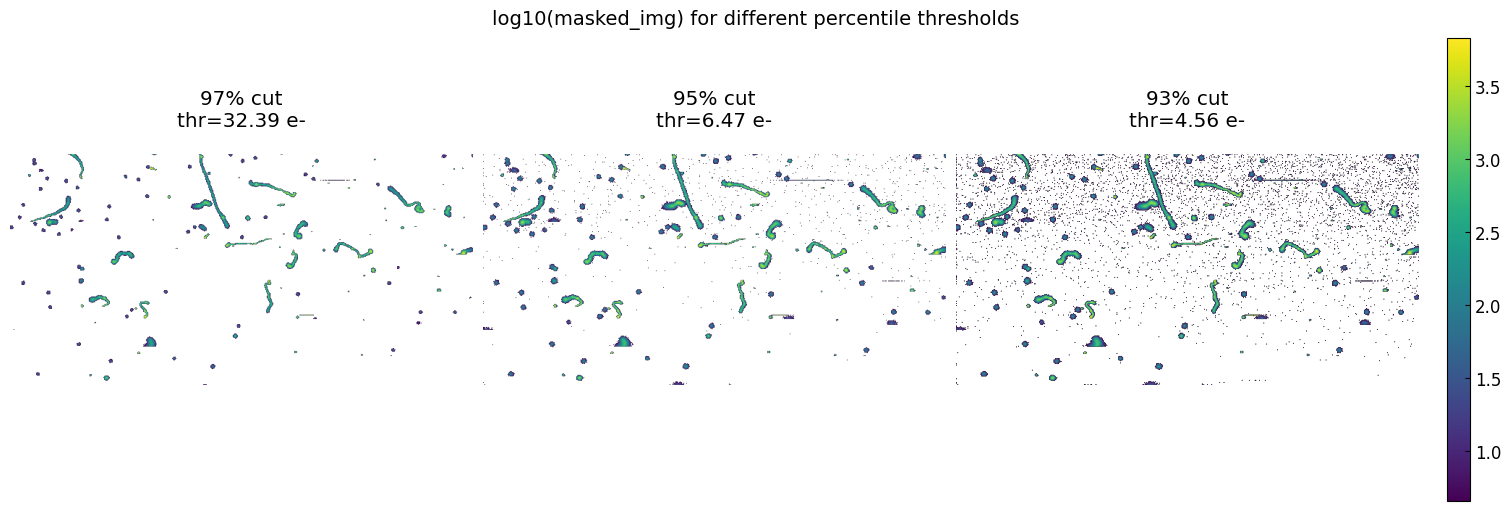

In [207]:
percentiles = [97, 95, 93]
fig, axes = plt.subplots(1, len(percentiles), figsize=(15, 5), constrained_layout=True)

for ax, p in zip(axes, percentiles):
    masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=p, fill_value=np.nan)
    ax.imshow(np.log10(masked_img), origin='lower')
    ax.set_title(f"{p}% cut\nthr={thr:.2f} e-")
    ax.axis('off')

plt.suptitle("log10(masked_img) for different percentile thresholds", fontsize=14)
plt.colorbar(ax.imshow(np.log10(masked_img), origin='lower'),
             ax=axes, orientation='vertical', fraction=0.03, pad=0.02)
plt.show()


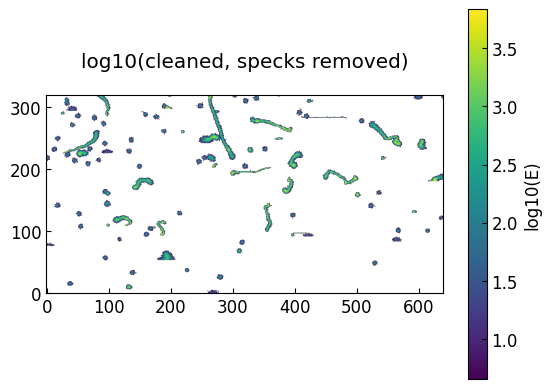

In [208]:
# 2) remove specks (e.g., anything < 20 pixels, adjust!)
clean_img, keep_clean, labeled = remove_small_components(masked_img, min_pixels=20, connectivity=2)
plt.figure(); plt.imshow(np.log10(clean_img), origin='lower'); plt.title("log10(cleaned, specks removed)"); plt.colorbar(label="log10(E)"); plt.show()

In [209]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(clean_img) & (clean_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

Estimated number of connected clusters: 90
[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]


In [210]:
# 3) build samples ONLY from retained components
X_raw_cleaned, idx_yx = make_samples_from_masked(clean_img)

In [211]:
# 4) fit GMM as before
results_cleaned = fit_gmms_over_K(X_raw_cleaned, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE)

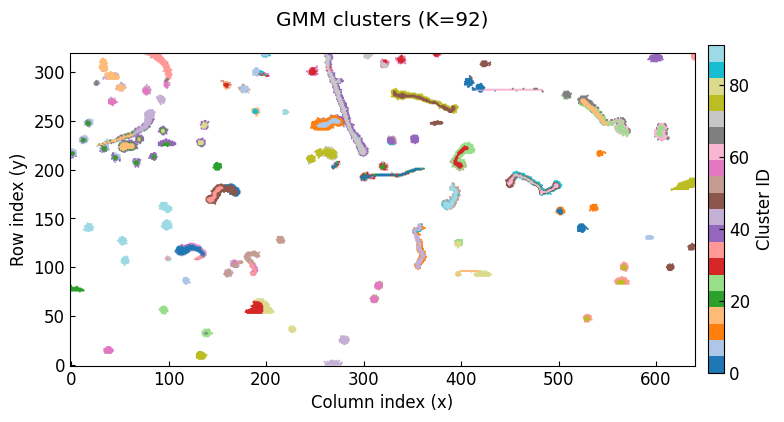

In [212]:
best = results_cleaned[0]
plot_fullframe_clusters(idx_yx, best["labels"], frame_size=clean_img.shape, title=f"GMM clusters (K={best['K']})")

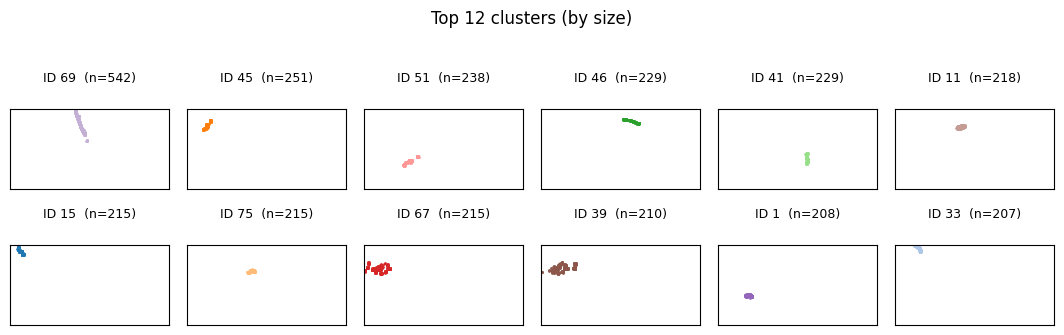

In [213]:
plot_cluster_gallery(idx_yx, best["labels"], clean_img.shape, top_n=12, cols=6)

### GMM (without speck removal)

In [214]:
masked_img, thr, keep = apply_percentile_threshold(ccd1, percentile=97, fill_value=np.nan)

In [215]:
# assuming 'clean_img' is your speck-removed array
mask = np.isfinite(masked_img) & (masked_img > 0)
structure = ndi.generate_binary_structure(2, 2)   # 8-connected
labeled, n_clusters = ndi.label(mask, structure=structure)

print(f"Estimated number of connected clusters: {n_clusters}")

# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

Estimated number of connected clusters: 139
[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


In [216]:
# 3) build samples ONLY from retained components
X_raw_thresh, idx_yx = make_samples_from_masked(masked_img)

In [217]:
# K_range is +5, -5 around the n_clusters value found above
K_RANGE = list(range(max(1, n_clusters - 5), n_clusters + 6))
print(K_RANGE)

[134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]


In [218]:
results_thresh = fit_gmms_over_K(X_raw_thresh, K_RANGE, reg_covar=REG_COVAR, random_state=RANDOM_STATE)

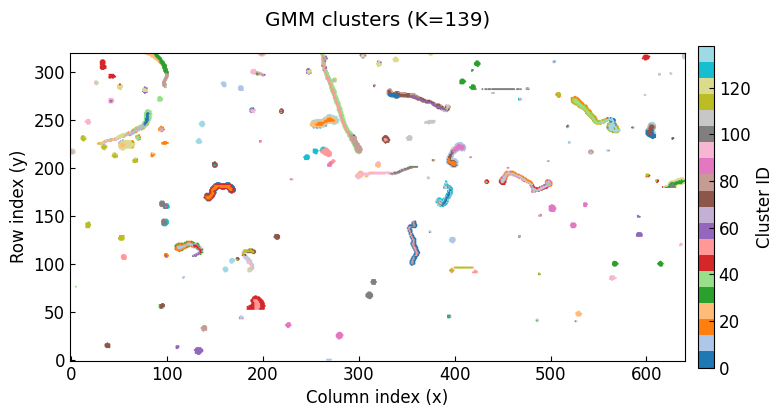

In [219]:
best = results_thresh[0]
plot_fullframe_clusters(idx_yx, best["labels"], frame_size=masked_img.shape, title=f"GMM clusters (K={best['K']})")

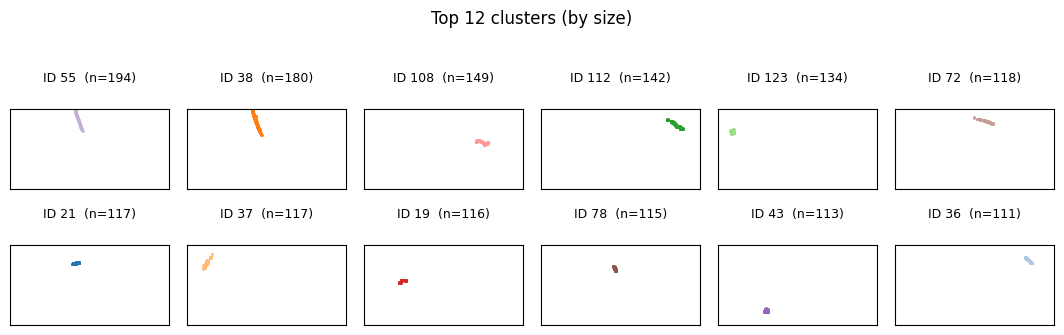

In [220]:
plot_cluster_gallery(idx_yx, best["labels"], clean_img.shape, top_n=12, cols=6)

In [221]:
ccd1.shape

len(ccd1[0])

640

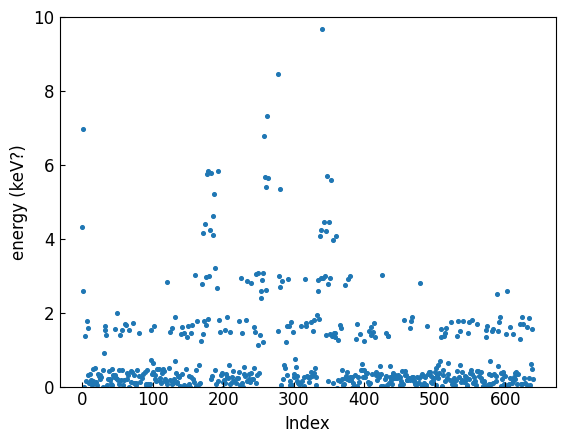

In [222]:
plt.scatter(np.arange(ccd1.shape[1]), ccd1[0],  s=7)
plt.xlabel("Index")
plt.ylabel("energy (keV?)")
plt.ylim(0, 10)
plt.show()

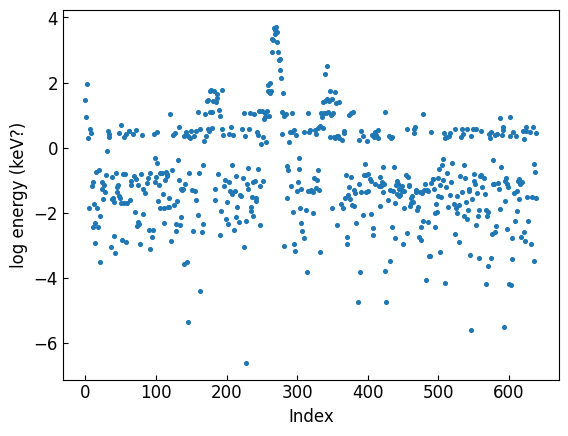

In [223]:
plt.scatter(np.arange(ccd1.shape[1]), np.log(ccd1[0]),  s=7)
plt.xlabel("Index")
plt.ylabel("log energy (keV?)")
plt.show()

In [224]:
print(ccd1[2].shape, ccd1.shape[0])

(640,) 320


In [225]:
ccd1[319][2]

np.float64(-0.15917633588065172)

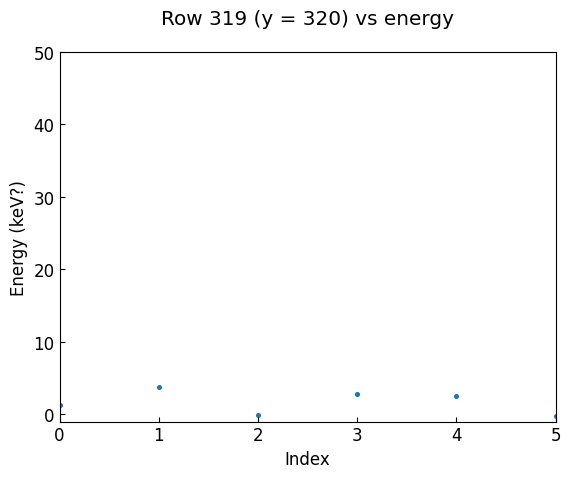

In [226]:
plt.scatter(np.arange(ccd1.shape[1]), ccd1[319], s=7)
plt.xlabel("Index")
plt.ylabel("Energy (keV?)")
plt.ylim(-1,50)
plt.xlim(0,5)
plt.title("Row 319 (y = 320) vs energy")
plt.show()

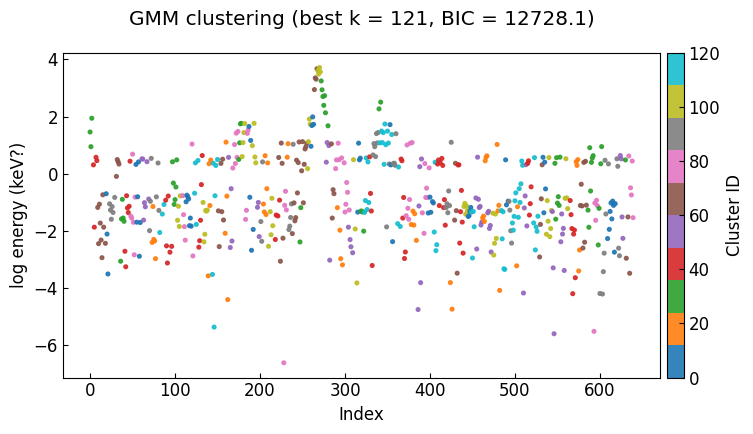

In [227]:
# Build data: x=index, y=log(energy) from row 0
x = np.arange(ccd1.shape[1])
y = np.log(ccd1[0])

# Keep only finite points
mask = np.isfinite(y)
x, y = x[mask], y[mask]

# Feature matrix (no scaling)
X = np.column_stack([x, y])

# Fit GMM (try several clusters, pick best by BIC)
lowest_bic = np.inf
best_gmm = None
best_k = None
for k in range(120, 140):  # test 1..6 clusters
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=0)
    gmm.fit(X)
    bic = gmm.bic(X)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
        best_k = k

# Predict labels and get cluster centers
labels = best_gmm.predict(X)
centers = best_gmm.means_

# Plot clusters
plt.figure(figsize=(8, 4.5))
scatter = plt.scatter(x, y, c=labels, s=7, cmap="tab10", alpha=0.9)

plt.xlabel("Index")
plt.ylabel("log energy (keV?)")
plt.title(f"GMM clustering (best k = {best_k}, BIC = {lowest_bic:.1f})")

cbar = plt.colorbar(scatter, pad=0.01)
cbar.set_label("Cluster ID")

plt.legend(loc="best")
plt.tight_layout()
plt.show()


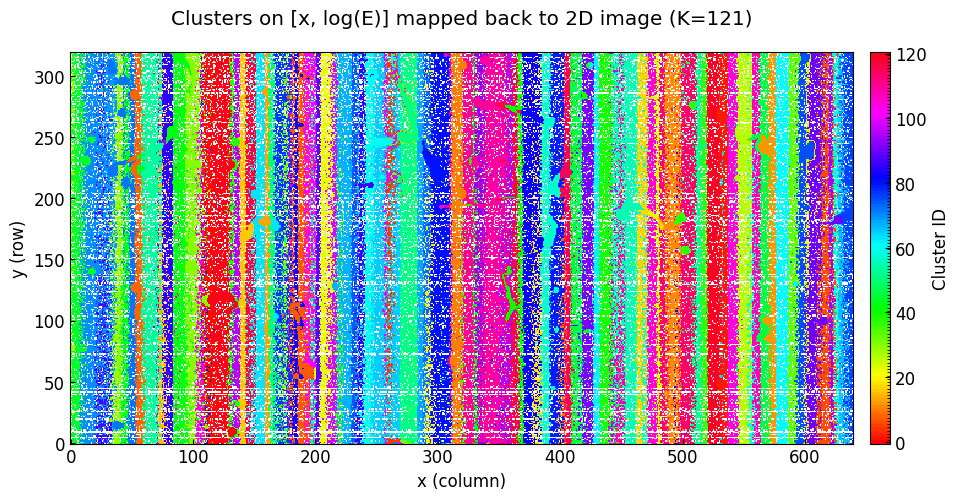

In [243]:
import matplotlib.colors as mcolors

# --- Use your existing best_gmm trained above ---
gmm = best_gmm  # already fitted on [x, log(E)] from your code
K = gmm.n_components

# --- Build features for ALL pixels: feature = [x_index, log(E)] ---
H, W = 320, 640
E_img = ccd1.astype(float)             # shape (320, 640)
logE = np.log(E_img)

mask = np.isfinite(logE)               # only valid pixels
ys, xs = np.nonzero(mask)              # pixel coordinates
X_full = np.column_stack([xs.astype(float), logE[mask].astype(float)])

# --- Predict cluster labels for each valid pixel ---
labels_full = gmm.predict(X_full)      # length = mask.sum()

# --- Rebuild a 2D label image ---
label_img = np.full((H, W), -1, dtype=int)   # -1 for invalid pixels
label_img[ys, xs] = labels_full

# --- Color with K distinct colors (and white for invalid) ---
cmap = plt.colormaps["hsv"].resampled(K)     # many distinct hues
cmap = cmap.with_extremes(bad="white", under="white")
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(-0.5, K + 0.5, 1),
    ncolors=K,
    clip=False
)

plt.figure(figsize=(10, 5))
im = plt.imshow(label_img, origin="lower", cmap=cmap, norm=norm, interpolation="nearest")
cbar = plt.colorbar(im, fraction=0.03, pad=0.02)
cbar.set_label("Cluster ID")
# Avoid 121 ticks on the bar; show coarse ticks instead:
step = 20 if K > 40 else 5
cbar.set_ticks(np.arange(0, K, step))

plt.title(f"Clusters on [x, log(E)] mapped back to 2D image (K={K})")
plt.xlabel("x (column)")
plt.ylabel("y (row)")
plt.tight_layout()
plt.show()

In [251]:
import uproot

In [252]:
file = "panaSKImg_clustersRec_avg_Image_5_Low_Temp_109_20250807_170213_15_ext1.root"

In [253]:
with uproot.open(file) as f:
    print(f.keys())

['clustersRec;1', 'info;1', 'process_config;1']


In [254]:
clustersRec_tree = f["clustersRec"]

In [255]:
df = clustersRec_tree.arrays(library="pd")

In [256]:
try:
    import awkward as ak
except Exception:
    ak = None

def to_list_maybe(x):
    # Handle common array-likes
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        return list(x)
    # Awkward arrays
    if ak is not None:
        try:
            return ak.to_list(x)
        except Exception:
            pass
    # Some awkward objects have .to_list()
    if hasattr(x, "to_list"):
        try:
            return x.to_list()
        except Exception:
            pass
    # Not an array -> return None so we can repeat later
    return None

# --- Choose columns (drop the blockers) ---
cols = [c for c in df.columns if c not in ["RUNID", "Nclusters"]]

# Use the first row (you said there's 1 row)
row = df.iloc[0]

# Find target length (e.g., 991) from the first array-like column
N = None
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is not None:
        N = len(seq)
        break
if N is None:
    raise ValueError("Couldn't find any array-like columns to expand.")

# Build dict of columns -> sequences (repeat scalars)
data = {}
for c in cols:
    seq = to_list_maybe(row[c])
    if seq is None:
        # scalar: repeat it N times
        data[c] = [row[c]] * N
    else:
        data[c] = seq

df_expanded = pd.DataFrame(data).reset_index(drop=True)

print(df_expanded.shape)  
df_expanded.head()

(130, 57)


,DX,DY,Energy,Energy_AVG,Energy_PS,Npix,PosX,PosY,Qmax,QmaxX,...,readout_end,readout_start,seed_nsig_delta,seed_nsig_max,seed_nsig_min,seed_nsig_pixels,sigma_seed_eV,wSTD_X,wSTD_XY,wSTD_Y
0,38.0,22.0,349.140503,111058.960938,126026.648438,371,153.556564,176.717758,5.535866,144.0,...,1.754616e+09,1.754611e+09,9806.511719,9824.365234,17.853212,"[19.767396926879883, 19.22641372680664, 18.175...",0.563483,8.901675,7.189656,4.913501
1,11.0,10.0,2.985785,-1341.195923,1077.756836,60,85.947876,214.410797,0.205912,86.0,...,1.754616e+09,1.754611e+09,350.096252,365.427826,15.331562,"[20.82303810119629, 17.126150131225586, 19.303...",0.563483,1.684169,1.622759,1.558932
2,21.0,6.0,2.767869,-1946.181885,999.096985,73,270.320648,2.191697,0.113200,271.0,...,1.754616e+09,1.754611e+09,182.264603,200.893036,18.628433,"[25.695201873779297, 35.061397552490234, 26.81...",0.563483,3.825072,2.837858,1.214784
3,2.0,1.0,0.045291,-64.366447,16.348391,2,343.261566,1.000000,0.033444,343.0,...,1.754616e+09,1.754611e+09,38.327431,59.352215,21.024782,"[59.35221481323242, 21.024782180786133]",0.563483,0.439493,0.310769,0.000000
4,6.0,5.0,48.461159,16604.621094,17492.664062,22,100.171860,109.704063,12.268317,100.0,...,1.754616e+09,1.754611e+09,21752.796875,21772.281250,19.484766,"[80.09197998046875, 1263.0574951171875, 890.47...",0.563483,0.720127,0.708834,0.697359


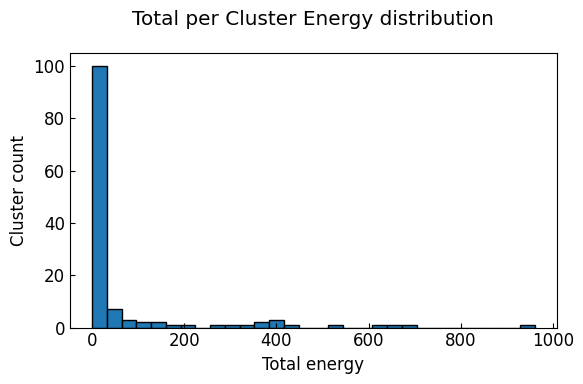

In [257]:
E = df_expanded["Energy"].to_numpy() 

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(E, bins=30, edgecolor="black")  # adjust bins if you like

ax.set_xlabel("Total energy")
ax.set_ylabel("Cluster count")
ax.set_title(f"Total per Cluster Energy distribution")

plt.tight_layout()
plt.show()

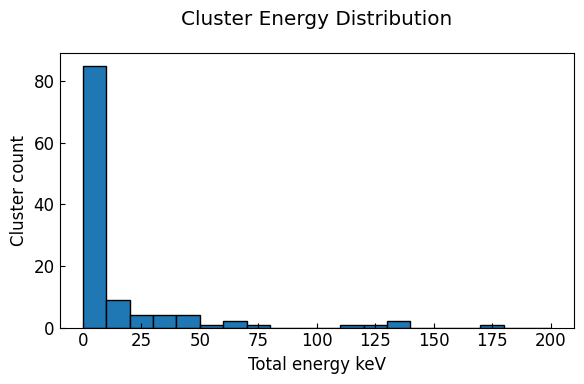

In [258]:
# keep only clusters with energy ≤ 200
E_cut = E[E <= 200]

fig, ax = plt.subplots(figsize=(6, 4))

# 20 fine-grained bins from 0 to 200
ax.hist(E_cut, bins=np.linspace(0, 200, 21), edgecolor="black")

ax.set_xlabel("Total energy keV")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution")

plt.tight_layout()
plt.show()


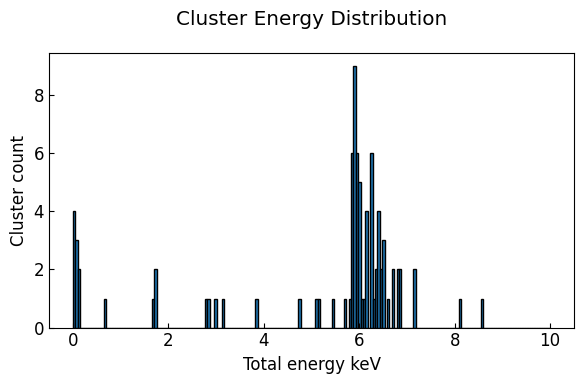

In [259]:
# keep only clusters with energy ≤ 200
E_cut = E[E <= 20]

fig, ax = plt.subplots(figsize=(6, 4))

# 20 fine-grained bins from 0 to 200
ax.hist(E_cut, bins=np.linspace(0, 10, 200), edgecolor="black")

ax.set_xlabel("Total energy keV")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution")

plt.tight_layout()
plt.show()

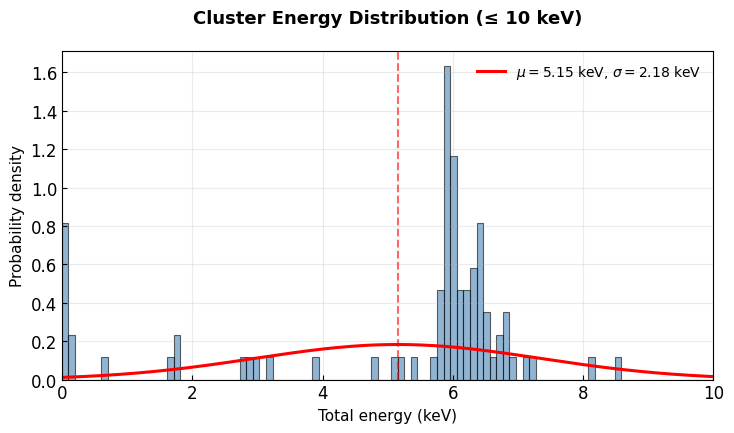

In [260]:
from scipy.stats import norm

lo, hi = 0.0, 10.0  # keV range
E_cut = E[(E >= lo) & (E <= hi)]

# --- Histogram configuration ---
bins = np.linspace(lo, hi, 100)  

fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Histogram as a normalized PDF (for Gaussian overlay)
counts, bin_edges, _ = ax.hist(
    E_cut, bins=bins, density=True, alpha=0.6,
    color="steelblue", edgecolor="black", linewidth=0.8
)

# --- Gaussian fit ---
mu, sigma = norm.fit(E_cut)
x = np.linspace(lo, hi, 1000)
y = norm.pdf(x, mu, sigma)
ax.plot(x, y, "r-", lw=2.2, label=rf"$\mu={mu:.2f}$ keV, $\sigma={sigma:.2f}$ keV")

# --- Plot styling ---
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)", fontsize=11)
ax.set_ylabel("Probability density", fontsize=11)
ax.set_title("Cluster Energy Distribution (≤ 10 keV)", fontsize=13, weight="bold")
ax.legend(frameon=False, fontsize=10)
ax.grid(alpha=0.25)

# --- Annotate peak visually ---
ax.axvline(mu, color="red", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


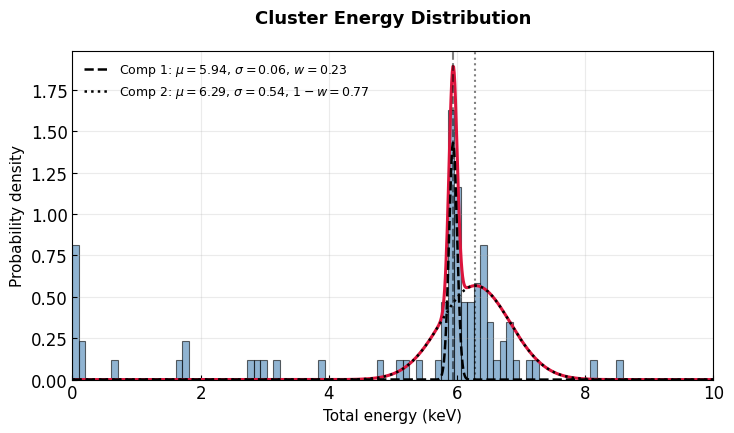

In [261]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# --- Data cut ---
lo, hi = 0.0, 10.0       # display range
fit_lo, fit_hi = 2.0, 10.0  # fit range
E_cut = E[(E >= lo) & (E <= hi)]

# --- Histogram configuration ---
bins = np.linspace(lo, hi, 100)
fig, ax = plt.subplots(figsize=(7.5, 4.5))

# Histogram as a normalized PDF (for mixture overlay)
counts, bin_edges, _ = ax.hist(
    E_cut, bins=bins, density=True, alpha=0.6,
    color="steelblue", edgecolor="black", linewidth=0.8
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Restrict data to fit range
mask_fit = (bin_centers >= fit_lo) & (bin_centers <= fit_hi)
x_fit = bin_centers[mask_fit]
y_fit = counts[mask_fit]

# --- Two-Gaussian mixture model ---
def two_gauss_pdf(x, w, mu1, sigma1, mu2, sigma2):
    w = np.clip(w, 1e-6, 1 - 1e-6)
    sigma1 = np.maximum(sigma1, 1e-6)
    sigma2 = np.maximum(sigma2, 1e-6)
    return w * norm.pdf(x, mu1, sigma1) + (1 - w) * norm.pdf(x, mu2, sigma2)

# Initial guesses based only on fit region
E_fit = E[(E >= fit_lo) & (E <= fit_hi)]
p30, p50, p70 = np.percentile(E_fit, [30, 50, 70])
std_all = np.std(E_fit) if np.std(E_fit) > 0 else (fit_hi - fit_lo) / 10
std1 = np.std(E_fit[E_fit <= p50]) if np.any(E_fit <= p50) else std_all / 2
std2 = np.std(E_fit[E_fit >  p50]) if np.any(E_fit >  p50) else std_all / 2

p0 = [0.5, p30, max(std1, 1e-3), p70, max(std2, 1e-3)]
bounds = ([0.0, fit_lo, 1e-6, fit_lo, 1e-6], [1.0, fit_hi, fit_hi - fit_lo, fit_hi, fit_hi - fit_lo])

# Fit to histogram density at bin centers (2–10 keV only)
popt, pcov = curve_fit(two_gauss_pdf, x_fit, y_fit, p0=p0, bounds=bounds)
w, mu1, s1, mu2, s2 = popt

# Sort components so mu1 < mu2
if mu1 > mu2:
    mu1, mu2 = mu2, mu1
    s1, s2   = s2, s1
    w        = 1 - w

# --- Plot mixture & components ---
x = np.linspace(lo, hi, 1000)
mix = two_gauss_pdf(x, w, mu1, s1, mu2, s2)
comp1 = w * norm.pdf(x, mu1, s1)
comp2 = (1 - w) * norm.pdf(x, mu2, s2)

ax.plot(x, mix, "-", lw=2.2, color="crimson")
ax.plot(x, comp1, "--", lw=1.8, color="black", label=fr"Comp 1: $\mu={mu1:.2f}$, $\sigma={s1:.2f}$, $w={w:.2f}$")
ax.plot(x, comp2, ":",  lw=1.8, color="black", label=fr"Comp 2: $\mu={mu2:.2f}$, $\sigma={s2:.2f}$, $1-w={1-w:.2f}$")

# Mark component means
ax.axvline(mu1, color="black", linestyle="--", alpha=0.5)
ax.axvline(mu2, color="black", linestyle=":",  alpha=0.5)

# --- Plot styling ---
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)", fontsize=11)
ax.set_ylabel("Probability density", fontsize=11)
ax.set_title("Cluster Energy Distribution", fontsize=13, weight="bold")
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()



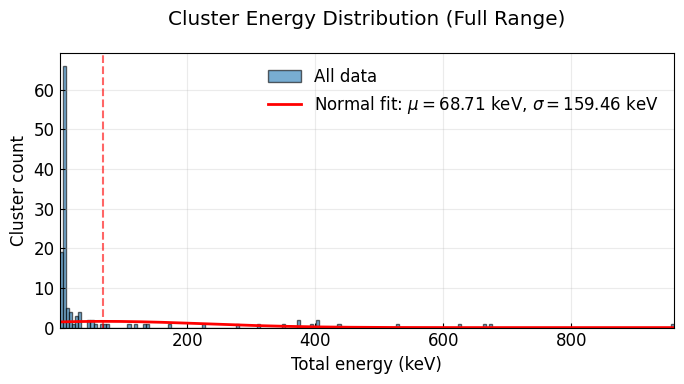

In [262]:
# choose bin range automatically based on data spread
lo, hi = np.min(E), np.max(E)
bins = np.linspace(lo, hi, 200)

# --- fit Gaussian (MLE) ---
mu, sigma = norm.fit(E)

# --- build Gaussian scaled to histogram COUNTS ---
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(E) * bin_width

# --- plot ---
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(E, bins=bins, edgecolor="black", alpha=0.6, label="All data")
ax.plot(x, y_counts, "r-", lw=2, label=rf"Normal fit: $\mu={mu:.2f}$ keV, $\sigma={sigma:.2f}$ keV")
ax.axvline(mu, color="r", ls="--", alpha=0.6)

# labels and aesthetics
ax.set_xlim(lo, hi)
ax.set_xlabel("Total energy (keV)")
ax.set_ylabel("Cluster count")
ax.set_title("Cluster Energy Distribution (Full Range)")
ax.legend(frameon=False)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

In [263]:
len(E)

130

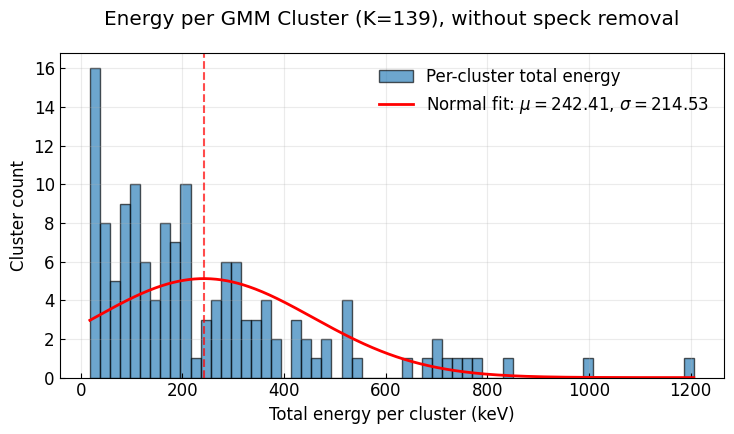

[per-cluster energy] mean=242.414 keV, std=214.534 keV, min=18.021, max=1206.358, K=139


In [264]:
from scipy.stats import norm

# ---- 1) choose best GMM by BIC (you already have 'results' from fit_gmms_over_K) ----
best = results_thresh[0]   # because you sorted by BIC in your helper
gmm     = best["model"]
labels  = best["labels"]
scaler  = best["scaler"]

# ---- 2) total energy per cluster (E is the 3rd column of X_raw) ----
# X_raw shape: (N, 3) with columns [x, y, E] in ORIGINAL units
E = X_raw_thresh[:, 2]

K = gmm.n_components
# totals[k] = sum of energies for all points assigned to cluster k
totals = np.zeros(K, dtype=float)
np.add.at(totals, labels, E)

# ---- 3) histogram of per-cluster total energies + Gaussian overlay (scaled to counts) ----
# choose binning automatically; adjust as you like (e.g., np.linspace(0, 10, 41))
num_bins = max(10, min(60, K))   # simple heuristic: up to 60 bins
lo, hi = float(np.min(totals)), float(np.max(totals))
bins = np.linspace(lo, hi, num_bins + 1)

# fit Gaussian to the *totals* distribution
mu, sigma = norm.fit(totals)

# scale Gaussian to histogram counts
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(totals) * bin_width

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.hist(totals, bins=bins, edgecolor="black", alpha=0.65, label="Per-cluster total energy")
ax.plot(x, y_counts, "r-", lw=2.0,
        label=rf"Normal fit: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$")
ax.axvline(mu, color="r", ls="--", alpha=0.7)

ax.set_xlabel("Total energy per cluster (keV)")
ax.set_ylabel("Cluster count")
ax.set_title(f"Energy per GMM Cluster (K={K}), without speck removal")
ax.legend(frameon=False)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"[per-cluster energy] mean={mu:.3f} keV, std={sigma:.3f} keV, "
      f"min={totals.min():.3f}, max={totals.max():.3f}, K={K}")


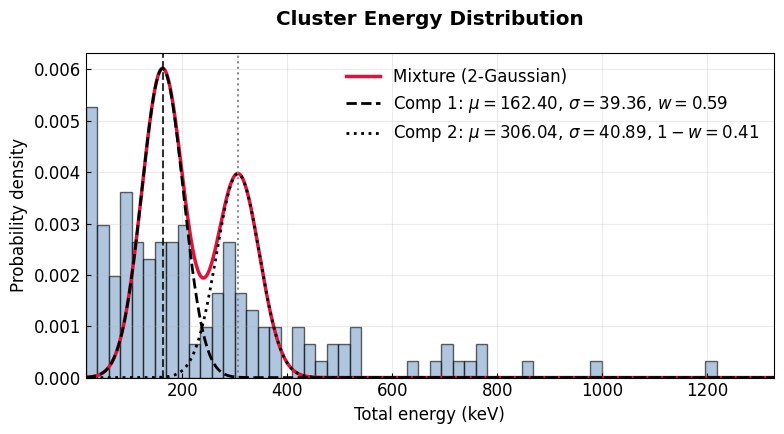

  Comp 1: weight=0.593, mu=162.400, sigma=39.358
  Comp 2: weight=0.407, mu=306.038, sigma=40.892
Fitted on 75 / 139 clusters within 100–400 keV.


In [269]:
# --- 1) Per-cluster total energies ---
E = X_raw_thresh[:, 2]
K = gmm.n_components
totals = np.zeros(K, float)
np.add.at(totals, labels, E)

# --- 2) Restrict fit to [100, 400] keV ---
fit_lo, fit_hi = 100, 400
mask = (totals >= fit_lo) & (totals <= fit_hi)
totals_fit = totals[mask]

# --- 3) Fit 2-Gaussian model only on this subset ---
X = totals_fit.reshape(-1, 1)
gmm2 = GaussianMixture(n_components=2, covariance_type="full",
                       n_init=10, random_state=0).fit(X)
w = gmm2.weights_.ravel()
m = gmm2.means_.ravel()
s = np.sqrt(gmm2.covariances_.ravel())

# order components by mean for nicer labels
order = np.argsort(m)
w, m, s = w[order], m[order], s[order]

# --- 4) Compute PDFs over the FULL range ---
lo_full, hi_full = max(0.0, totals.min()*0.9), totals.max()*1.1
x = np.linspace(lo_full, hi_full, 1500)
pdf1 = w[0] * norm.pdf(x, m[0], s[0])
pdf2 = w[1] * norm.pdf(x, m[1], s[1])
pdf_mix = pdf1 + pdf2

# --- 5) Plot full histogram and curves ---
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.hist(totals, bins=60, range=(lo_full, hi_full),
        density=True, alpha=0.6, color="#7aa0c9", edgecolor="black")

ax.plot(x, pdf_mix, color="crimson", lw=2.5, label="Mixture (2-Gaussian)")
ax.plot(x, pdf1, "k--", lw=2, label=fr"Comp 1: $\mu={m[0]:.2f}$, $\sigma={s[0]:.2f}$, $w={w[0]:.2f}$")
ax.plot(x, pdf2, "k:",  lw=2, label=fr"Comp 2: $\mu={m[1]:.2f}$, $\sigma={s[1]:.2f}$, $1-w={w[1]:.2f}$")

ax.axvline(m[0], color="k", ls="--", alpha=0.8)
ax.axvline(m[1], color="gray", ls=":", alpha=0.9)

ax.set_title("Cluster Energy Distribution", fontweight="bold")
ax.set_xlabel("Total energy (keV)")
ax.set_ylabel("Probability density")
ax.set_xlim(lo_full, hi_full)
ax.legend(frameon=False, loc="upper right")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

for i, (wi, mi, si) in enumerate(zip(w, m, s), 1):
    print(f"  Comp {i}: weight={wi:.3f}, mu={mi:.3f}, sigma={si:.3f}")
print(f"Fitted on {totals_fit.size} / {totals.size} clusters within 100–400 keV.")



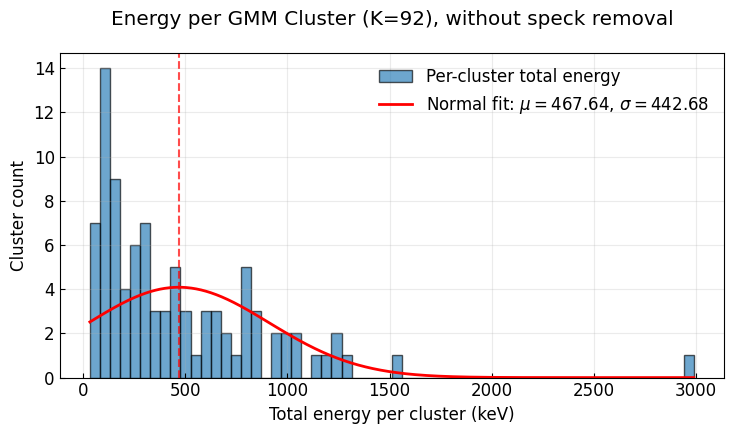

[per-cluster energy] mean=467.643 keV, std=442.684 keV, min=31.809, max=2990.720, K=92


In [242]:
from scipy.stats import norm

# ---- 1) choose best GMM by BIC (you already have 'results' from fit_gmms_over_K) ----
best = results_cleaned[0]   # because you sorted by BIC in your helper
gmm     = best["model"]
labels  = best["labels"]
scaler  = best["scaler"]

# ---- 2) total energy per cluster (E is the 3rd column of X_raw) ----
# X_raw shape: (N, 3) with columns [x, y, E] in ORIGINAL units
E = X_raw_cleaned[:, 2]

K = gmm.n_components
# totals[k] = sum of energies for all points assigned to cluster k
totals = np.zeros(K, dtype=float)
np.add.at(totals, labels, E)

# ---- 3) histogram of per-cluster total energies + Gaussian overlay (scaled to counts) ----
# choose binning automatically; adjust as you like (e.g., np.linspace(0, 10, 41))
num_bins = max(10, min(60, K))   # simple heuristic: up to 60 bins
lo, hi = float(np.min(totals)), float(np.max(totals))
bins = np.linspace(lo, hi, num_bins + 1)

# fit Gaussian to the *totals* distribution
mu, sigma = norm.fit(totals)

# scale Gaussian to histogram counts
bin_width = bins[1] - bins[0]
x = np.linspace(lo, hi, 1000)
y_counts = norm.pdf(x, mu, sigma) * len(totals) * bin_width

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.hist(totals, bins=bins, edgecolor="black", alpha=0.65, label="Per-cluster total energy")
ax.plot(x, y_counts, "r-", lw=2.0,
        label=rf"Normal fit: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$")
ax.axvline(mu, color="r", ls="--", alpha=0.7)

ax.set_xlabel("Total energy per cluster (keV)")
ax.set_ylabel("Cluster count")
ax.set_title(f"Energy per GMM Cluster (K={K}), without speck removal")
ax.legend(frameon=False)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

print(f"[per-cluster energy] mean={mu:.3f} keV, std={sigma:.3f} keV, "
      f"min={totals.min():.3f}, max={totals.max():.3f}, K={K}")

In [265]:
print("Scaler mean/std:", scaler.mean_, scaler.scale_)
print("E (first 10):", E[:10])
print("min/max E:", E.min(), E.max())
print("Sum of all E:", E.sum())
print("Expected total energy (~5 keV per cluster):", np.mean(totals))

Scaler mean/std: [204.29492188 293.48193359   5.48430958] [ 73.27763584 170.64947359   1.26175701]
E (first 10): [3.69640117 3.63422915 3.51622852 3.73875117 3.59214113 3.98876553
 3.93540567 3.69531104 4.23279285 5.25488173]
min/max E: 3.508755325748213 8.822004171550768
Sum of all E: 33695.59808289085
Expected total energy (~5 keV per cluster): 242.41437469705653
